# Nootebok description

Train the ensemble for each model and each series. Then, evaluate the performance and save the results

***PS: also in this case, all the procedures and functions have been built in a general way adaptable for a many-to-many scenario***  

In [1]:
!python --version # Python 3.10.12

Python 3.10.12


# Libraries, Settings, and Directories

In [2]:
!pip install numpy==1.25.2
!pip install rioxarray==0.15.5
!pip install matplotlib==3.7.1
!pip install xarray==2023.7.0
!pip install netCDF4==1.6.5
!pip install pandas==2.0.3
!pip install seaborn==0.13.1
!pip install rasterio==1.3.10
!pip install imageio==2.31.6
!pip install geopandas==0.13.2
!pip install cmasher==1.8.0
!pip install scipy==1.11.4
!pip install cftime==1.6.3
!pip install tensorflow==2.15.0 # cuDNN 8.9	CUDA 12.2 # keras 2.15.0
!pip install great-circle-calculator==1.3.1
!pip install matplotlib_scalebar==0.8.1
!pip install adjustText==1.1.1
!pip install geopy==2.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00
  Attempting uninstall: cftime
    Found existing installation: cftime 1.6.4
    Uninstalling cftime-1.6.4:
      Successfully uninstalled cftime-1.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: geopy
    Found existing installation: geopy 2.3.0
    Uninstalling geopy-2.3.0:
      Successfully uninstalled geopy-2.3.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import rioxarray
from netCDF4 import num2date
import rasterio
from rasterio.plot import show
import pandas as pd
import copy
import datetime
from datetime import datetime, timedelta
import seaborn as sns
import geopandas as gpd
import datetime
import os
from itertools import compress
import random
import re
import math
import gc
import scipy.stats
import warnings

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import sys
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
# from keras import activations

tf.keras.backend.clear_session()

In [4]:
# keras.__version__
# !pip show keras

In [5]:
!nvcc --version #release 12.2, V12.2.140

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [6]:
#Check if a GPU is available and used
try:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found at :0')
  print('Found GPU at: {}'.format(device_name))
  gpu = True
except SystemError:
  print("No GPU found...\n")
  gpu = False

No GPU found...



In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [8]:
# Import modules
sys.path.append('/.../python_modules/')

from data_handle import *
from plot_functions import *
from models_creation import *
from models_training_testing import *

## General settings

In [9]:
# select the temporal frequency:
temp_freq = "W"
step_ahead = 0 # 0 means seq2val; >0 means seq2seq
past_meteo_images = 104 # 104 weeks means two years
focus_on_sensors = "Racconigi_00417910001"
# Available sensors:
#  'Racconigi_00417910001',
#  'Savigliano_00421510001',
#  'Vottignasco_00425010001'

In [10]:
# To automatic define directories
# output_type
if (step_ahead > 0):
  output_type = "seq2seq"
else:
  output_type = "seq2val"

# input sequence
if (past_meteo_images == 104):
  input_sequence_length = "2Y"

## Directories

In [11]:
## Define your directories

data_path = "/.../Datasets/"
## subfolder in /datasets
splits_target_objects_main_path = f"{data_path}training_validation_test_sets_{input_sequence_length}/target_water_table_depth/"
# target data splitted into training validation and test - ready for deep learning models
splits_target_numpy_objects_path = f"{data_path}training_validation_test_sets_{input_sequence_length}/target_water_table_depth/{output_type}/"

# weather data splitted into training validation and test - ready for deep learning models
splits_features_objects_main_path = f"{data_path}training_validation_test_sets_{input_sequence_length}/features_meteorological_variables/"
# weather data not splitted
unsplitted_features_path = f"{data_path}pre_processed_meteoOI_ARPA_Grana_Maira/"

# directory for model log and saving trained parameters
log_path = "/.../Scripts/logs_weekly_models/local_models/"
log_path = f"{log_path}{output_type}/training2016_validation_2022test"

# results saving path
results_path = "/.../Results/water_table_Grana_Maira/"
results_path_output_type = f"{results_path}training2016_validation_2022test/{output_type}/"

# Import data

## Target: Water Table Depth

#### DataFrame

In [12]:
## Load full series with gaps introduced due to splitting
files_target_main_path = os.listdir(splits_target_objects_main_path)

target_splited_ds_file = [re.search(f'.*{focus_on_sensors}.*(.csv)$', files_target_main_path[i]) for i in range(len(files_target_main_path))]
target_splited_ds_file = [files_target_main_path[i] for i in range(len(target_splited_ds_file)) if target_splited_ds_file[i] is not None]; target_splited_ds_file

['Racconigi_00417910001_training_target_ds.csv',
 'Racconigi_00417910001_validation_target_ds.csv',
 'Racconigi_00417910001_test_target_ds.csv',
 'Racconigi_00417910001_all_sets_target_ds.csv']

In [13]:
water_table_depth_training_ds = pd.read_csv(f"{splits_target_objects_main_path}{focus_on_sensors}_training_target_ds.csv", dtype={"ID_code":'str'})
water_table_depth_training_ds = water_table_depth_training_ds.astype({"Date":'datetime64[ns]'})

water_table_depth_validation_ds = pd.read_csv(f"{splits_target_objects_main_path}{focus_on_sensors}_validation_target_ds.csv", dtype={"ID_code":'str'})
water_table_depth_validation_ds = water_table_depth_validation_ds.astype({"Date":'datetime64[ns]'})

water_table_depth_test_ds = pd.read_csv(f"{splits_target_objects_main_path}{focus_on_sensors}_test_target_ds.csv", dtype={"ID_code":'str'})
water_table_depth_test_ds = water_table_depth_test_ds.astype({"Date":'datetime64[ns]'})

water_table_depth_all_sets_ds = pd.read_csv(f"{splits_target_objects_main_path}{focus_on_sensors}_all_sets_target_ds.csv", dtype={"ID_code":'str'})
water_table_depth_all_sets_ds = water_table_depth_all_sets_ds.astype({"Date":'datetime64[ns]'})

In [14]:
water_table_depth_training_ds

,Date,ID_code,Value
0,2001-01-14,00417910001,4.100952
1,2001-01-21,00417910001,4.127381
2,2001-01-28,00417910001,4.195714
3,2001-02-04,00417910001,4.258333
4,2001-02-11,00417910001,4.336667
...,...,...,...
744,2015-11-29,00417910001,4.490000
745,2015-12-06,00417910001,4.496667
746,2015-12-13,00417910001,4.499524
747,2015-12-20,00417910001,4.500952


In [15]:
sensor_id = water_table_depth_training_ds["ID_code"].unique()[0]; sensor_id

'00417910001'

In [16]:
water_table_depth_training_ds.dtypes

Date       datetime64[ns]
ID_code            object
Value             float64
dtype: object

In [17]:
# Write Municipality and ID Code for plot titles
sensor_municipality_id = focus_on_sensors.replace("_"," ")
sensor_municipality_id

'Racconigi 00417910001'

In [18]:
sensor_municipality = " ".join(re.findall("[a-zA-Z]+", sensor_municipality_id))
sensor_municipality

'Racconigi'

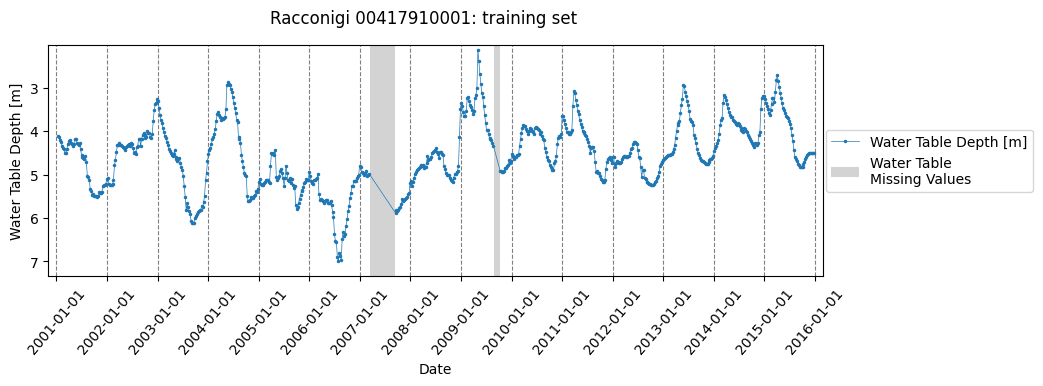

In [19]:
plot_ts_with_gaps(y = water_table_depth_training_ds["Value"].values,
                  date = water_table_depth_training_ds["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_municipality_id + ": training set", width = 10,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.28)

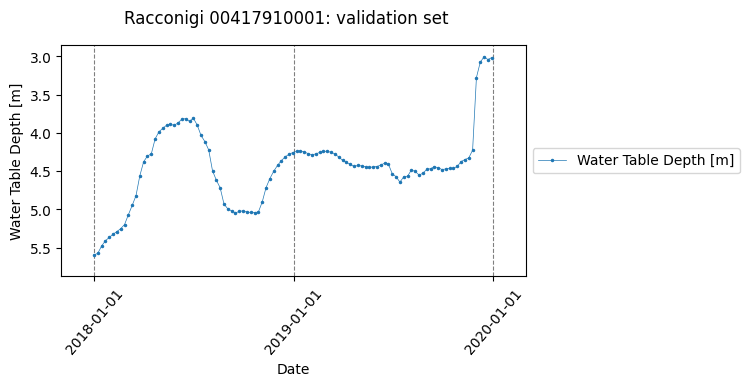

In [20]:
plot_ts_with_gaps(y = water_table_depth_validation_ds["Value"].values,
                  date = water_table_depth_validation_ds["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_municipality_id + ": validation set", width = 6,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.475)

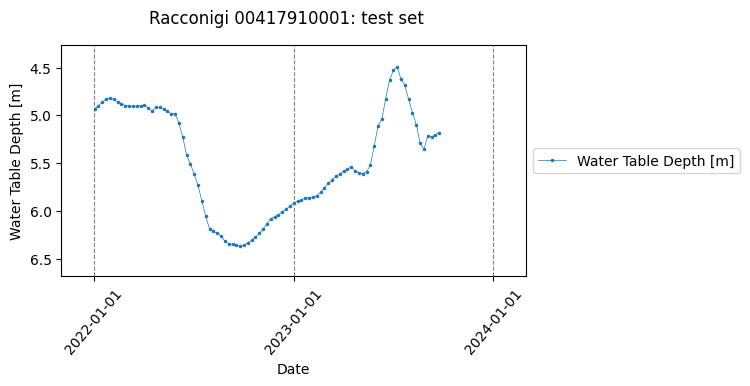

In [21]:
plot_ts_with_gaps(y = water_table_depth_test_ds["Value"].values,
                  date = water_table_depth_test_ds["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_municipality_id + ": test set", width = 6,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.475)

#### Model Output objects

In [22]:
files_target_numpy = os.listdir(splits_target_numpy_objects_path)

target_splited_numpy_file = [re.search(f'.*{focus_on_sensors}.*', files_target_numpy[i]) for i in range(len(files_target_numpy))]
target_splited_numpy_file = [files_target_numpy[i] for i in range(len(target_splited_numpy_file)) if target_splited_numpy_file[i] is not None]
target_splited_numpy_file

['Racconigi_00417910001_training_target_values.npy',
 'Racconigi_00417910001_training_target_normalized_values.npy',
 'Racconigi_00417910001_training_target_dates.npy',
 'Racconigi_00417910001_validation_target_values.npy',
 'Racconigi_00417910001_validation_target_normalized_values.npy',
 'Racconigi_00417910001_validation_target_dates.npy',
 'Racconigi_00417910001_test_target_values.npy',
 'Racconigi_00417910001_test_target_normalized_values.npy',
 'Racconigi_00417910001_test_target_dates.npy']

In [23]:
### Load splited numpy objects (the actual output of the following models)

## Training
water_table_depth_training_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_training_target_values.npy")
water_table_depth_training_normalized_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_training_target_normalized_values.npy")

## Validation
water_table_depth_validation_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_validation_target_values.npy")
water_table_depth_validation_normalized_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_validation_target_normalized_values.npy")

## Test
water_table_depth_test_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_test_target_values.npy")
water_table_depth_test_normalized_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_test_target_normalized_values.npy")

#### Normalization factors

In [24]:
files_target_main_path = os.listdir(splits_target_objects_main_path)

target_normalization_factors_file = [re.search(f'.*{focus_on_sensors}.*(.npy)$', files_target_main_path[i]) for i in range(len(files_target_main_path))]
target_normalization_factors_file = [files_target_main_path[i] for i in range(len(target_normalization_factors_file)) if target_normalization_factors_file[i] is not None]; target_normalization_factors_file

['Racconigi_00417910001_training_target_mean.npy',
 'Racconigi_00417910001_training_target_std.npy']

In [25]:
water_table_depth_training_mean = np.load(f"{splits_target_objects_main_path}{focus_on_sensors}_training_target_mean.npy")
water_table_depth_training_std = np.load(f"{splits_target_objects_main_path}{focus_on_sensors}_training_target_std.npy")

In [26]:
print("Training mean[m]:", water_table_depth_training_mean)

Training mean[m]: 4.540472906907098


In [27]:
print("Training standard deviation[m]:", water_table_depth_training_std)

Training standard deviation[m]: 0.7611342140269624


## Features: Meteorological variables

### Model Input objects

In [28]:
files_features_main_path = os.listdir(splits_features_objects_main_path)

features_splited_numpy_file = [re.search(f'.*{focus_on_sensors}.*(.npy)$', files_features_main_path[i]) for i in range(len(files_features_main_path))]
features_splited_numpy_file = [files_features_main_path[i] for i in range(len(features_splited_numpy_file)) if features_splited_numpy_file[i] is not None]; features_splited_numpy_file

['Racconigi_00417910001_training_image_sequences.npy',
 'Racconigi_00417910001_training_image_sequences_dates.npy',
 'Racconigi_00417910001_training_normalized_image_sequences.npy',
 'Racconigi_00417910001_training_month_OHE.npy',
 'Racconigi_00417910001_validation_image_sequences.npy',
 'Racconigi_00417910001_validation_normalized_image_sequences.npy',
 'Racconigi_00417910001_validation_image_sequences_dates.npy',
 'Racconigi_00417910001_validation_month_OHE.npy',
 'Racconigi_00417910001_test_image_sequences.npy',
 'Racconigi_00417910001_test_normalized_image_sequences.npy',
 'Racconigi_00417910001_test_image_sequences_dates.npy',
 'Racconigi_00417910001_test_month_OHE.npy']

In [29]:
## Training
meteorological_training_input_sequences_normalized = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_training_normalized_image_sequences.npy")
month_OHE_training = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_training_month_OHE.npy")

## Validation
meteorological_validation_input_sequences_normalized = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_validation_normalized_image_sequences.npy")
month_OHE_validation = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_validation_month_OHE.npy")

## Test
meteorological_test_input_sequences_normalized = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_test_normalized_image_sequences.npy")
month_OHE_test = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_test_month_OHE.npy")

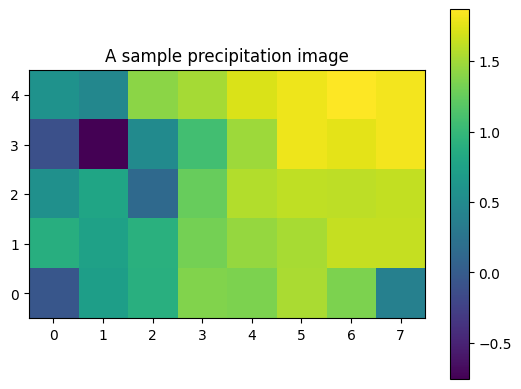

In [30]:
plt.imshow(meteorological_training_input_sequences_normalized[-1,23,:,:,1], cmap = 'viridis', origin="lower")
plt.title("A sample precipitation image")
plt.colorbar()

### Normalization factors

In [31]:
files_features_main_path = os.listdir(splits_features_objects_main_path)

features_netcdf_file = [re.search(f'.*{focus_on_sensors}.*(.nc)$', files_features_main_path[i]) for i in range(len(files_features_main_path))]
features_netcdf_file = [files_features_main_path[i] for i in range(len(features_netcdf_file)) if features_netcdf_file[i] is not None]; features_netcdf_file

['Racconigi_00417910001_training_meteorological_means.nc',
 'Racconigi_00417910001_training_meteorological_std.nc',
 'Racconigi_00417910001_training_meteorological_features_ds.nc',
 'Racconigi_00417910001_validation_meteorological_features_ds.nc',
 'Racconigi_00417910001_test_meteorological_features_ds.nc']

In [32]:
meteorological_training_means_ds = xarray.open_dataset(f"{splits_features_objects_main_path}{focus_on_sensors}_training_meteorological_means.nc")
meteorological_training_std_ds = xarray.open_dataset(f"{splits_features_objects_main_path}{focus_on_sensors}_training_meteorological_std.nc")

In [33]:
meteorological_training_means_ds["prec"].values

array(2.5644202, dtype=float32)

In [34]:
meteorological_training_means_ds["tmax"].values

array(282.72906, dtype=float32)

In [35]:
meteorological_training_means_ds["tmin"].values

array(282.72906, dtype=float32)

### Weekly Mean Precipitations

In [36]:
os.listdir(unsplitted_features_path)

['meteo_data_GM_weekly.nc', 'weekly_mean_precipitations_GM.csv']

In [37]:
# Useful in plots
weekly_mean_precipitations = pd.read_csv(f"{unsplitted_features_path}weekly_mean_precipitations_GM.csv")
weekly_mean_precipitations = weekly_mean_precipitations.astype({"Date":'datetime64[ns]'})
weekly_mean_precipitations

,prec,Date
0,0.001065,1990-01-07
1,0.000000,1990-01-14
2,0.000000,1990-01-21
3,0.279988,1990-01-28
4,0.678878,1990-02-04
...,...,...
1781,1.194062,2024-02-25
1782,21.381340,2024-03-03
1783,9.854746,2024-03-10
1784,0.824634,2024-03-17


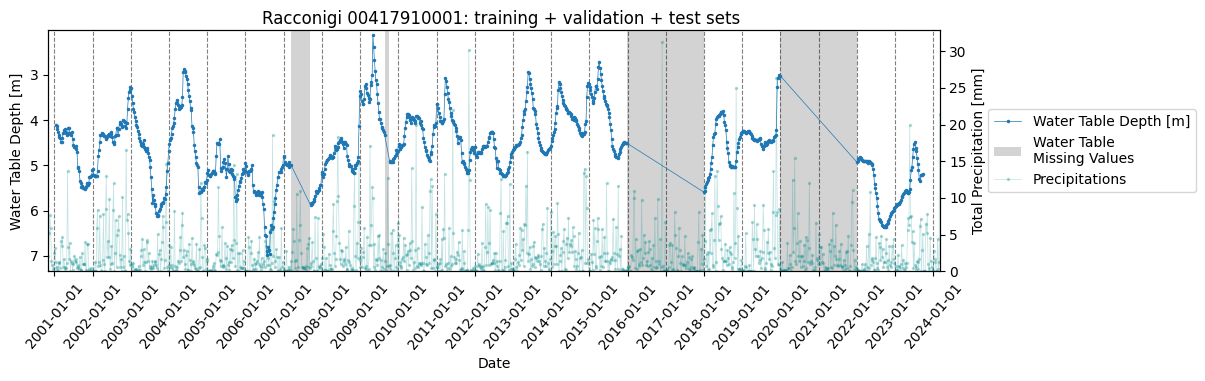

In [38]:
plot_ts_with_gaps(y = water_table_depth_all_sets_ds["Value"].values,
                  date = water_table_depth_all_sets_ds["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_municipality_id + ": training + validation + test sets", width = 10,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.295,
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

# Multiple initialization & training

In [39]:
# Function for initialize and train each ensemble member
# Because of the magic comands of tensorboad it has not been possible to insert it into a module

%load_ext tensorboard

def multi_initialization_training(model_type, initial_iteration, end_iteration,
                                  models_path,
                                  output_neurons, input_month_encodings, past_meteo_images,
                                  dropout, kernel_regularizer,
                                  batch, nepochs, lr, loss, clipnorm,
                                  new_folder_name, model_name, history_name,
                                  metrics,
                                  x_train, y_train,
                                  x_val, y_val,
                                  kernel_initializer = "HeUniform",
                                  bias_regularizer = None,
                                  batch_normalization = False,
                                  perc_dropout_unpwavenet = 0):

  for i in range(initial_iteration,end_iteration+1):

    print("Iteration: "+ str(i) + "\n")
    new_folder_name_i = new_folder_name + "_" + str(i)
    model_name_i = model_name + "_" + str(i)
    history_name_i = history_name + "_" + str(i)
    tf.keras.backend.clear_session()


    if (model_type == "UnPWaveNet"):
      model = meteo_model_time_dist_dilated_unpwavenet(output_neurons = output_neurons,
                                      past_meteorological_images = past_meteo_images,
                                      input_month_encodings = input_month_encodings,
                                      dropout = dropout,
                                      perc_dropout = 0.15,
                                      perc_dropout_unpwavenet = perc_dropout_unpwavenet,
                                      channels_dilated_conv = 32,
                                      kernel_dilated_conv = 4,
                                      channels_1x1conv = 8,
                                      gated_activation = True,
                                      kernel_regularizer = kernel_regularizer,
                                      kernel_regularizer_dilated_conv = kernel_regularizer,
                                      kernel_regularizer_1x1_conv = kernel_regularizer,
                                      bias_regularizer = bias_regularizer,
                                      bias_regularizer_dilated_conv = bias_regularizer,
                                      bias_regularizer_1x1_conv = bias_regularizer,
                                      kernel_initializer = kernel_initializer,
                                      batch_normalization = batch_normalization)

    if (model_type == "LSTM"):
      model = meteo_model_time_dist_dilated_lstm(output_neurons = output_neurons,
                                          lstm_units = 32,
                                          input_month_encodings = input_month_encodings,
                                          past_meteorological_images = past_meteo_images,
                                          lstm_activation = "leaky_relu",
                                          kernel_initializer = kernel_initializer,
                                          dropout = dropout,
                                          perc_dropout = 0.15,
                                          kernel_regularizer = kernel_regularizer,
                                          kernel_regularizer_lstm = kernel_regularizer,
                                          bias_regularizer = bias_regularizer,
                                          bias_regularizer_lstm = bias_regularizer,
                                          recurrent_regularizer_lstm = kernel_regularizer,
                                          batch_normalization = batch_normalization)

    print(model_type + " " + str(str(i)) + " initialized. ")
    if (i == 1):
        model.summary()

    # Compile the model
    logdir, filename_model, filename_weights, filename_hist =  setting_model(model,
                                    models_dir = models_path,
                                    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9,  nesterov=True, clipnorm=clipnorm),
                                    new_folder_name = new_folder_name_i, initial_epoch = 0, logdir = None,
                                    loss = loss, metrics = metrics,
                                    model_name = model_name_i, history_name = history_name_i)

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
    %tensorboard --logdir={logdir}


    save_freq = math.ceil((y_train.shape[0]/batch))*100

    # Training
    history_model = train_model(model,
                x_train = x_train,
                y_train = y_train,
                x_val = x_val,
                y_val = y_val,
                epochs = nepochs, batch_size = batch, initial_epoch = 0,
                tensorboard_callback = tensorboard_callback,
                filename_model = filename_model,
                filename_weights = filename_weights,
                filename_hist = filename_hist,
                save = True,  save_freq = save_freq)


    del model, history_model
    gc.collect()

    print("---------------------------------------------------\n")


  return print("All models are trained and saved")

In [ ]:
models_path = f'{log_path}/{sensor_municipality}'; models_path

In [ ]:
batch_unpwavenet = 8
nepochs_unpwavenet = 80
lr_unpwavenet = 0.001
clipnorm_unpwavenet = 1.0
kernel_regularization_unpwavenet = tf.keras.regularizers.L2(0.0075)
perc_dropout_unpwavenet = 0

In [ ]:
#UnPWaveNet

# uncomment to train
# multi_initialization_training(model_type = "UnPWaveNet",
#                                   initial_iteration = 1, end_iteration = 10,
#                                   input_month_encodings = True,
#                                   past_meteo_images = past_meteo_images,
#                                   models_path = models_path,
#                                   output_neurons = 1, dropout = "classic",
#                                   kernel_regularizer = kernel_regularization_unpwavenet,
#                                   batch = batch_unpwavenet, nepochs = nepochs_unpwavenet, lr = lr_unpwavenet,
#                                   clipnorm = clipnorm_unpwavenet,
#                                   perc_dropout_unpwavenet = perc_dropout_unpwavenet,
#                                   loss = 'mean_squared_error',
#                                   new_folder_name = focus_on_sensors + "_time_dist_UnPWaveNet",
#                                   model_name = focus_on_sensors + "_time_dist_UnPWaveNet",
#                                   history_name = focus_on_sensors + "_time_dist_UnPWaveNet",
#                                   metrics = ['MeanSquaredError'],
#                                   x_train = [meteorological_training_input_sequences_normalized, month_OHE_training],
#                                   y_train = water_table_depth_training_normalized_values,
#                                   x_val = [meteorological_validation_input_sequences_normalized, month_OHE_validation],
#                                   y_val = water_table_depth_validation_normalized_values)

In [ ]:
batch_lstm = 8
nepochs_lstm = 80
lr_lstm = 0.001
clipnorm_lstm = 1.0
kernel_regularization_lstm = tf.keras.regularizers.L2(0.0005)

In [ ]:
#LSTM

# uncomment to train
# multi_initialization_training(model_type = "LSTM",
#                                   initial_iteration = 1, end_iteration = 10,
#                                   input_month_encodings = True,
#                                   past_meteo_images = past_meteo_images,
#                                   models_path = models_path,
#                                   output_neurons = 1, dropout = "classic",
#                                   kernel_regularizer = kernel_regularization_lstm,
#                                   batch = batch_lstm, nepochs = nepochs_lstm, lr = lr_lstm,
#                                   clipnorm = clipnorm_lstm,
#                                   loss = 'mean_squared_error',
#                                   new_folder_name = focus_on_sensors + "_time_dist_LSTM",
#                                   model_name = focus_on_sensors + "_time_dist_LSTM",
#                                   history_name = focus_on_sensors + "_time_dist_LSTM",
#                                   metrics = ['MeanSquaredError'],
#                                   x_train = [meteorological_training_input_sequences_normalized, month_OHE_training],
#                                   y_train = water_table_depth_training_normalized_values,
#                                   x_val = [meteorological_validation_input_sequences_normalized, month_OHE_validation],
#                                   y_val = water_table_depth_validation_normalized_values)

# Ensemble predictions and evaluations on test

In [42]:
gc.collect()

7405

In [43]:
models_path = f'{log_path}/{sensor_municipality}'
model_type = ['UnPWaveNet','LSTM']
number_of_models = 10

In [44]:
training_features = [meteorological_training_input_sequences_normalized, month_OHE_training]

In [45]:
test_features = [meteorological_test_input_sequences_normalized, month_OHE_test]

In [46]:
# Initialize an empty double-list: outer index model types, inner index ensemble member
empty_models_list = [[[] for j in range(number_of_models)] for i in range(len(model_type))]

In [ ]:
# Load the members
ensemble_models_list = [load_models(models_list = empty_models_list[i],
                                   path = models_path, model_ID = model_type[i],
                                    load = "model") for i in range(len(model_type))]

In [ ]:
# Compute predictions on test
ensemble_target_predictions_test = [np.stack([ensemble_models_list[j][i].predict(test_features) for i in range(0,len(ensemble_models_list[j]))]) for j in range(len(model_type))]

In [49]:
ensemble_mean_target_prediction_test = [ensemble_target_predictions_test[i].mean(axis = 0) for i in range(len(model_type))]

In [50]:
ensemble_median_target_prediction_test = [np.median(ensemble_target_predictions_test[i], axis = 0) for i in range(len(model_type))]

In [51]:
# de-normalize mean predictions
ensemble_mean_target_prediction_test = [(ensemble_mean_target_prediction_test[i] * water_table_depth_training_std) + water_table_depth_training_mean for i in range(len(model_type))]

# de-normalize median predictions
ensemble_median_target_prediction_test = [(ensemble_median_target_prediction_test[i] * water_table_depth_training_std) + water_table_depth_training_mean for i in range(len(model_type))]

In [52]:
# compute prediction variance
ensemble_target_predictions_test_not_normalized = [copy.deepcopy(ensemble_target_predictions_test[i]) for i in range(len(model_type))]
ensemble_target_predictions_test_not_normalized = [(ensemble_target_predictions_test_not_normalized[i] * water_table_depth_training_std) + water_table_depth_training_mean for i in range(len(model_type))]
ensemble_std_target_prediction_test = [ensemble_target_predictions_test_not_normalized[i].std(axis = 0) for i in range(len(model_type))]

In [53]:
ensemble_2std_target_prediction_test = [2 * ensemble_std_target_prediction_test[i] for i in range(len(model_type))]

In [54]:
# 0.25 quantile
ensemble_1quart_target_prediction_test = [np.quantile(ensemble_target_predictions_test_not_normalized[i], 0.25, axis = 0) for i in range(len(model_type))]
# 0.75 quantile
ensemble_3quart_target_prediction_test = [np.quantile(ensemble_target_predictions_test_not_normalized[i], 0.75, axis = 0) for i in range(len(model_type))]
# IQR
ensemble_IQR_target_prediction_test = [ensemble_3quart_target_prediction_test[i] - ensemble_1quart_target_prediction_test[i] for i in range(len(model_type))]

## Metrics

### Mean

In [55]:
# Training evaluation metrics
# Adopting mean computed on the training set
test_rmse = [round(compute_RMSE(ensemble_mean_target_prediction_test[i],
                           water_table_depth_test_values), 3) for i in range(len(ensemble_mean_target_prediction_test))]


test_NRMSE = [round(compute_NRMSE(predictions = ensemble_mean_target_prediction_test[i],
                            truth = water_table_depth_test_values,
                            normalization = "range",
                            denominator = water_table_depth_training_values.max() - water_table_depth_training_values.min()), 3) for i in range(len(ensemble_mean_target_prediction_test))]

test_BIAS =  [round(compute_BIAS(predictions = ensemble_mean_target_prediction_test[i],
                            truth = water_table_depth_test_values), 3) for i in range(len(ensemble_mean_target_prediction_test))]

test_NBIAS = [round(compute_NBIAS(predictions = ensemble_mean_target_prediction_test[i],
                            truth = water_table_depth_test_values,
                            max_value = water_table_depth_training_values.max(),
                            min_value = water_table_depth_training_values.min()), 3) for i in range(len(ensemble_mean_target_prediction_test))]

test_MAPE = [round(compute_mape(predictions = ensemble_mean_target_prediction_test[i],
                            truth = water_table_depth_test_values), 3) for i in range(len(ensemble_mean_target_prediction_test))]

test_rcorr = [round(compute_rcorrelation_coeff(predictions = ensemble_mean_target_prediction_test[i].flatten(),
                            truth = water_table_depth_test_values.flatten()), 3) for i in range(len(ensemble_mean_target_prediction_test))]

test_NSE = [round(compute_nash_sutcliffe(predictions = ensemble_mean_target_prediction_test[i],
                            truth = water_table_depth_test_values,
                            truth_mean = water_table_depth_training_mean), 3) for i in range(len(ensemble_mean_target_prediction_test))]

test_kge = [round(compute_kge(predictions = ensemble_mean_target_prediction_test[i].flatten(),
                            truth = water_table_depth_test_values.flatten(),
                            truth_mean = water_table_depth_training_mean,
                            truth_sd = compute_RMSE(water_table_depth_test_values,
                                        water_table_depth_training_mean)), 3) for i in range(len(ensemble_mean_target_prediction_test))]

metrics_ensemble_mean_df = pd.DataFrame({'Model': model_type,
                                      'RMSE[m]': test_rmse,
                                      'NRMSE': test_NRMSE,
                                      'BIAS[m]': test_BIAS,
                                      'NBIAS': test_NBIAS,
                                      'MAPE': test_MAPE,
                                      'r': test_rcorr,
                                      'NSE': test_NSE,
                                      'KGE': test_kge})

metrics_ensemble_mean_df

,Model,RMSE[m],NRMSE,BIAS[m],NBIAS,MAPE,r,NSE,KGE
0,UnPWaveNet,0.495,0.102,-0.456,-0.094,0.082,0.948,0.792,0.396
1,LSTM,0.337,0.069,-0.219,-0.045,0.048,0.891,0.904,0.370


In [ ]:
# Save the metrics
#metrics_ensemble_mean_df.to_csv(f'{results_path_output_type}{sensor_municipality}/{focus_on_sensors}_{"_".join(model_type)}_metrics_ensemble_mean_prediction.csv', index=False)

### Median

In [56]:
# Training evaluation metrics on the median prediction
# Adopting mean computed on the training set
test_rmse = [round(compute_RMSE(ensemble_median_target_prediction_test[i],
                           water_table_depth_test_values), 3) for i in range(len(ensemble_median_target_prediction_test))]


test_NRMSE = [round(compute_NRMSE(predictions = ensemble_median_target_prediction_test[i],
                            truth = water_table_depth_test_values,
                            normalization = "range",
                            denominator = water_table_depth_training_values.max() - water_table_depth_training_values.min()), 3) for i in range(len(ensemble_mean_target_prediction_test))]

test_BIAS =  [round(compute_BIAS(predictions = ensemble_median_target_prediction_test[i],
                            truth = water_table_depth_test_values), 3) for i in range(len(ensemble_median_target_prediction_test))]

test_NBIAS = [round(compute_NBIAS(predictions = ensemble_median_target_prediction_test[i],
                            truth = water_table_depth_test_values,
                            max_value = water_table_depth_training_values.max(),
                            min_value = water_table_depth_training_values.min()), 3) for i in range(len(ensemble_median_target_prediction_test))]

test_MAPE = [round(compute_mape(predictions = ensemble_median_target_prediction_test[i],
                            truth = water_table_depth_test_values), 3) for i in range(len(ensemble_median_target_prediction_test))]

test_rcorr = [round(compute_rcorrelation_coeff(predictions = ensemble_median_target_prediction_test[i].flatten(),
                            truth = water_table_depth_test_values.flatten()), 3) for i in range(len(ensemble_median_target_prediction_test))]


test_NSE = [round(compute_nash_sutcliffe(predictions = ensemble_median_target_prediction_test[i],
                            truth = water_table_depth_test_values,
                            truth_mean = water_table_depth_training_mean), 3) for i in range(len(ensemble_median_target_prediction_test))]

test_kge = [round(compute_kge(predictions = ensemble_median_target_prediction_test[i].flatten(),
                            truth = water_table_depth_test_values.flatten(),
                            truth_mean = water_table_depth_training_mean,
                            truth_sd = compute_RMSE(water_table_depth_test_values,
                                        water_table_depth_training_mean)), 3) for i in range(len(ensemble_median_target_prediction_test))]


metrics_ensemble_median_df = pd.DataFrame({'Model': model_type,
                                      'RMSE[m]': test_rmse,
                                      'NRMSE': test_NRMSE,
                                      'BIAS[m]': test_BIAS,
                                      'NBIAS': test_NBIAS,
                                      'MAPE': test_MAPE,
                                      'r': test_rcorr,
                                      'NSE': test_NSE,
                                      'KGE': test_kge})

metrics_ensemble_median_df

,Model,RMSE[m],NRMSE,BIAS[m],NBIAS,MAPE,r,NSE,KGE
0,UnPWaveNet,0.506,0.104,-0.463,-0.095,0.083,0.935,0.783,0.408
1,LSTM,0.354,0.073,-0.247,-0.051,0.051,0.892,0.894,0.375


In [ ]:
# Save the metrics
#metrics_ensemble_median_df.to_csv(f'{results_path_output_type}{sensor_municipality}/{focus_on_sensors}_{"_".join(model_type)}_metrics_ensemble_median_prediction.csv', index=False)

## Plots

In [57]:
model_colors = ["tab:orange","tab:purple"]

### Seq2val

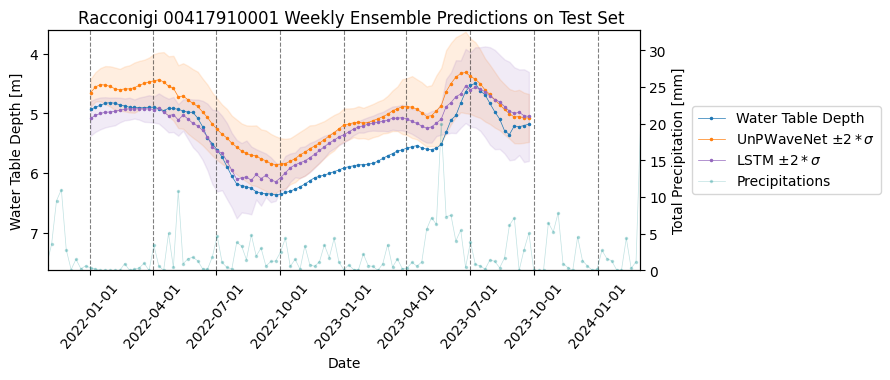

In [58]:
plot_ts_with_gaps(y = water_table_depth_test_ds["Value"].values, date = water_table_depth_test_ds["Date"].values,
                  title = sensor_municipality_id + " Weekly Ensemble Predictions on Test Set",
                  temp_freq = 'W',
                  width = 7, height = 3, y_lim = 0.2, linewidth = 0.5, scatter = False,
                  y_pred_list = ensemble_mean_target_prediction_test,
                  y_error_list = ensemble_2std_target_prediction_test,
                  model_names = [model_type[i] + r' $\pm 2*\sigma$' for i in range(len(model_type))],
                  model_colors = model_colors,
                  x_legend = 1.42,
                  xticks_freq = "QS",
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values, #test_date
                  saving_path = None)
#f'{results_path_output_type}{sensor_municipality}/{focus_on_sensors}_{"_".join(model_type)}_ensemble_mean_predictions.png'

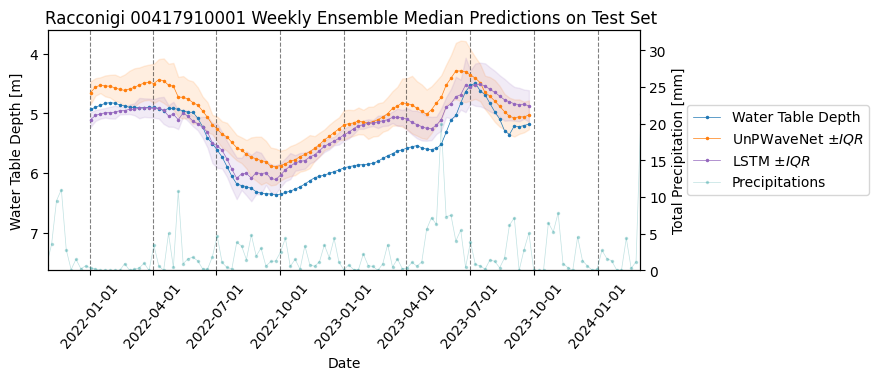

In [ ]:
plot_ts_with_gaps(y = water_table_depth_test_ds["Value"].values, date = water_table_depth_test_ds["Date"].values,
                  title = sensor_municipality_id + " Weekly Ensemble Median Predictions on Test Set",
                  temp_freq = 'W',
                  width = 7, height = 3, y_lim = 0.2, linewidth = 0.5, scatter = False,
                  y_pred_list = ensemble_median_target_prediction_test,
                  y_error_list = ensemble_IQR_target_prediction_test, #ensemble_2std_target_prediction_test
                  model_names = [model_type[i] + r' $\pm IQR$' for i in range(len(model_type))],
                  model_colors = model_colors,
                  x_legend = 1.4,
                  xticks_freq = "QS",
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values, #test_date
                  saving_path = None)
# f'{results_path_output_type}{sensor_municipality}/{focus_on_sensors}_{"_".join(model_type)}_ensemble_median_predictions.png'

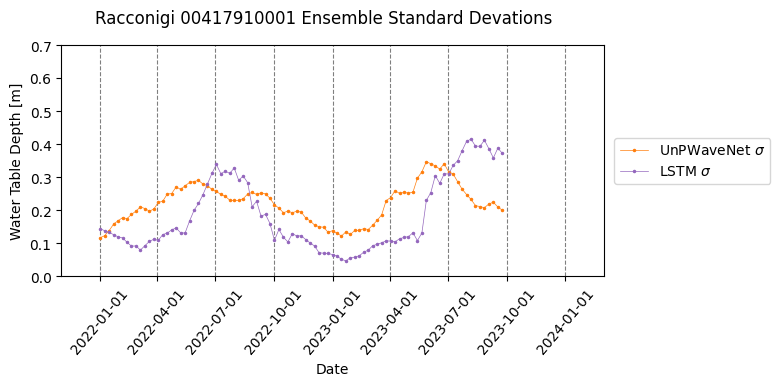

In [ ]:
plot_ts_with_gaps(y = None, date = water_table_depth_test_ds["Date"].values,
                  title = sensor_municipality_id + " Ensemble Standard Devations",
                  temp_freq = 'W',
                  y_bottom_limit = 0,
                  y_upper_limit = 0.7,
                  label_base_series=None,
                  reverse_axis = False,
                  width = 7, height = 3, y_lim = 0.2, linewidth = 0.5,
                  y_pred_list = ensemble_std_target_prediction_test,
                  model_names = [model_type[i] + r' $\sigma$' for i in range(len(model_type))],
                  model_colors = model_colors,
                  x_legend = 1.32,
                  xticks_freq = "QS", #test_date
                  saving_path = None)

#f'{results_path_output_type}{sensor_municipality}/{focus_on_sensors}_{"_".join(model_type)}_ensemble_sd.png'

In [ ]:
test_APE = [compute_ape(predictions = ensemble_mean_target_prediction_test[i],
                       truth = water_table_depth_test_values) for i in range(len(model_type))]

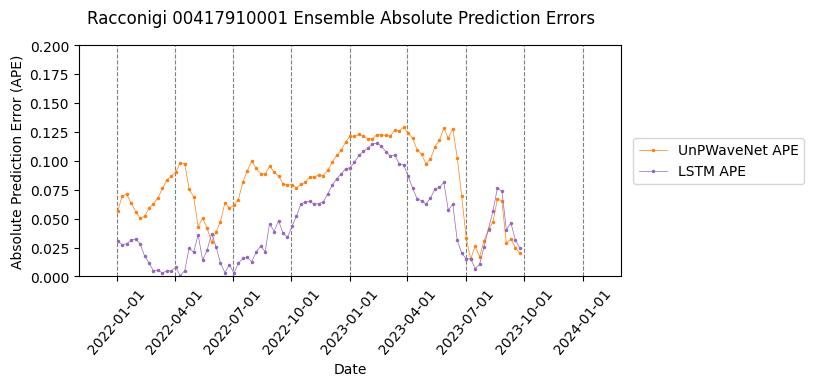

In [ ]:
plot_ts_with_gaps(y = None, date = water_table_depth_test_ds["Date"].values,
                  title = sensor_municipality_id + " Ensemble Absolute Prediction Errors",
                  ylabel_water_table= "Absolute Prediction Error (APE)",
                  temp_freq = 'W',
                  y_bottom_limit = 0,
                  y_upper_limit = 0.2,
                  label_base_series=None,
                  reverse_axis = False,
                  width = 7, height = 3, y_lim = 0.2, linewidth = 0.5,
                  y_pred_list = test_APE,
                  model_names = [model_type[i] + ' APE' for i in range(len(model_type))],
                  model_colors = model_colors,
                  x_legend = 1.35,
                  xticks_freq = "QS", #test_date
                  saving_path = None)

# f'{results_path_output_type}{sensor_municipality}/{focus_on_sensors}_{"_".join(model_type)}_APE_ensemble_mean_prediction.png'